In [1]:
%load_ext autoreload
%load_ext autotime

time: 331 µs (started: 2023-06-21 11:55:53 -07:00)


In [2]:
import sys
sys.path.append("../")
import warnings
warnings.filterwarnings('ignore')

time: 679 µs (started: 2023-06-21 11:55:53 -07:00)


In [3]:
import dask
import dask.dataframe as dd
import json
import numpy as np
import pandas as pd
from dask import compute, delayed
from dask.distributed import Client, Future, LocalCluster, as_completed, get_client, wait
from typing import Union

time: 1.85 s (started: 2023-06-21 11:55:53 -07:00)


In [4]:
client = Client(LocalCluster(n_workers=16, local_directory=f"/var/tmp/playground-cm1-multiple"))
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:41221/status,
Dashboard: http://127.0.0.1:41221/status,Workers: 16
Total threads: 48,Total memory: 125.47 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32859,Workers: 16
Dashboard: http://127.0.0.1:41221/status,Total threads: 48
Started: Just now,Total memory: 125.47 GiB
Comm: tcp://127.0.0.1:37737,Total threads: 3
Dashboard: http://127.0.0.1:37261/status,Memory: 7.84 GiB
Nanny: tcp://127.0.0.1:46613,


time: 2.64 s (started: 2023-06-21 11:55:55 -07:00)


In [5]:
log_dir = "/p/vast1/iopp/recorder_app_logs/montage/nodes-32/_parquet"

time: 648 µs (started: 2023-06-21 11:55:58 -07:00)


In [6]:
all_view = dd.read_parquet(f"{log_dir}/*.parquet").compute()
all_view

,index,proc,rank,thread_id,cat,io_cat,tstart,tend,func_id,level,...,app,proc_name,file_name,size,acc_pat,bandwidth,duration,tmid,file_id,proc_id
0,1,111084,0,314672,0,3,0.242405,0.242414,__xstat64,0,...,mImgtbl,mImgtbl#lassen247#111084#35184372403504,/p/gpfs1/iopp/temp/montage/2854964/2,0,0,0.000000,0.000009,2424094,1571755611461267775,-4245390515581891276
1,2,111084,0,314672,0,3,0.242502,0.242732,fopen64,0,...,mImgtbl,mImgtbl#lassen247#111084#35184372403504,/p/gpfs1/iopp/temp/montage/2854964/2/run/Kimag...,0,0,0.000000,0.000230,2426168,7638324191939094055,-4245390515581891276
2,3,111084,0,314672,0,3,0.242851,0.242868,opendir,0,...,mImgtbl,mImgtbl#lassen247#111084#35184372403504,/p/gpfs1/iopp/temp/montage/2854964/2,0,0,0.000000,0.000017,2428593,1571755611461267775,-4245390515581891276
3,4,111084,0,314672,0,3,0.242946,0.242956,__xstat64,0,...,mImgtbl,mImgtbl#lassen247#111084#35184372403504,/p/gpfs1/iopp/temp/montage/2854964/2,0,0,0.000000,0.000010,2429507,1571755611461267775,-4245390515581891276
4,5,111084,0,314672,0,3,0.243006,0.243016,__xstat64,0,...,mImgtbl,mImgtbl#lassen247#111084#35184372403504,/p/gpfs1/iopp/temp/montage/2854964,0,0,0.000000,0.000010,2430107,5347462497940582382,-4245390515581891276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235304,2332457,41731,31,317888,0,2,1.604730,1.604747,fwrite,0,...,mAddMPI,mAddMPI#lassen246#41731#35184372406720,/p/gpfs1/iopp/temp/montage/2854964/1/run/ngc33...,96920,0,5469.237793,0.000017,16047384,7686174940287124680,8238577613900339652
235305,2332458,41731,31,317888,0,2,1.604971,1.604992,fwrite,0,...,mAddMPI,mAddMPI#lassen246#41731#35184372406720,/p/gpfs1/iopp/temp/montage/2854964/1/run/ngc33...,96920,0,4359.911133,0.000021,16049814,7686174937900816169,8238577613900339652
235306,2332459,41731,31,317888,0,3,1.605062,1.605241,fclose,0,...,mAddMPI,mAddMPI#lassen246#41731#35184372406720,/p/gpfs1/iopp/temp/montage/2854964/1/run/ngc33...,0,0,0.000000,0.000179,16051513,7686174940287124680,8238577613900339652
235307,2332460,41731,31,317888,0,3,1.605244,1.605379,fclose,0,...,mAddMPI,mAddMPI#lassen246#41731#35184372406720,/p/gpfs1/iopp/temp/montage/2854964/1/run/ngc33...,0,0,0.000000,0.000135,16053112,7686174937900816169,8238577613900339652


time: 23.1 s (started: 2023-06-21 11:55:58 -07:00)


In [7]:
from enum import Enum


class AccessPattern(Enum):
    SEQUENTIAL = 0
    RANDOM = 1


class IOCategory(Enum):
    READ = 1
    WRITE = 2
    METADATA = 3


CAT_POSIX = 0
TIME_PRECISION = 1e7

VIEW_TYPES = ['trange', 'file_name', 'proc_name']
LOGICAL_VIEW_TYPES = ['app_name', 'node_name', 'rank', 'file_dir', 'file_regex']

ACC_PAT_SUFFIXES = ['time', 'size', 'count']
APP_NAME_COL = 'app_name'
BW_BINS = [  # bw_ranges = [0, 1, 128, 1024, 1024*64]
    0,  # -- 'critical'
    1024 ** 2,  # 1MB -- 'very high'
    1024 ** 2 * 16,  # 16MB -- 'high',
    1024 ** 2 * 16 * 16,  # 256MB -- 'medium',
    1024 ** 3,  # 1GB -- 'low',
    1024 ** 3 * 16,  # 16GB -- 'very low',
    1024 ** 3 * 16 * 4,  # 64GB -- 'trivial',
    1024 ** 4  # 1TB
]
DELTA_BINS = [
    0,
    0.001,
    0.01,
    0.1,
    0.25,
    0.5,
    0.75,
    0.9
]
DELTA_BIN_NAMES = [
    'none',
    'trivial',
    'very low',
    'low',
    'medium',
    'high',
    'very high',
    'critical'
]
DERIVED_MD_OPS = ['close', 'open', 'seek', 'stat']
FILE_COL = 'file_name'
FILE_DIR_COL = 'file_dir'
FILE_REGEX_COL = 'file_regex'
FILE_REGEX_PLACEHOLDER = '[0-9]'
HLM_AGG = {
    'duration': [sum],
    'index': ['count'],
    'size': [min, max, sum],
}
IO_CATS = [io_cat.value for io_cat in list(IOCategory)]
IO_TYPES = ['read', 'write', 'metadata']
IS_INVERSED = dict(
    duration=False,
    bw=True,
    iops=True,
    intensity=False,
    att_perf=True
)
IS_NORMALIZED = dict(
    duration=False,
    bw=True,
    iops=True,
    intensity=True,
    att_perf=True
)
NODE_NAME_COL = 'node_name'
PROC_COL = 'proc_name'
PROC_NAME_SEPARATOR = '#'
RANK_COL = 'rank'
TRANGE_COL = 'trange'
XFER_SIZE_BINS = [
    -np.inf,
    4 * 1024.0,
    16 * 1024.0,
    64 * 1024.0,
    256 * 1024.0,
    1 * 1024.0 * 1024.0,
    4 * 1024.0 * 1024.0,
    16 * 1024.0 * 1024.0,
    64 * 1024.0 * 1024.0,
    np.inf
]
XFER_SIZE_BIN_LABELS = [
    '<4 KB',
    '4-16 KB',
    '16-64 KB',
    '64-256 KB',
    '256 KB-1 MB',
    '1-4 MB',
    '4-16 MB',
    '16-64 MB',
    '>64 MB',
]
XFER_SIZE_BIN_NAMES = [
    '<4 KB',
    '4 KB',
    '16 KB',
    '64 KB',
    '256 KB',
    '1 MB',
    '4 MB',
    '16 MB',
    '64 MB',
    '>64 MB'
]

time: 4.74 ms (started: 2023-06-21 11:56:21 -07:00)


In [8]:
def set_tranges(df: pd.DataFrame, tranges: Union[Future, np.ndarray]):
    tranges = tranges.result() if isinstance(tranges, Future) else tranges
    return df.assign(trange=np.digitize(df['tmid'], bins=tranges, right=True))


def _compute_tranges(global_min_max: dict, precision=TIME_PRECISION):
    tmid_min, tmid_max = global_min_max['tmid']
    tranges = np.arange(tmid_min, tmid_max, precision)
    return get_client().scatter(tranges)


def _flatten_column_names(ddf: dd.DataFrame):
    ddf.columns = ['_'.join(tup).rstrip('_') for tup in ddf.columns.values]
    return ddf


def _set_derived_columns(ddf: dd.DataFrame):
    # Derive `io_cat` columns
    for col_suffix, col_value in zip(['time', 'size', 'count'], ['duration_sum', 'size_sum', 'index_count']):
        for io_cat in list(IOCategory):
            col_name = f"{io_cat.name.lower()}_{col_suffix}"
            ddf[col_name] = 0.0 if col_suffix is 'time' else 0
            ddf[col_name] = ddf[col_name].mask(ddf['io_cat'] == io_cat.value, ddf[col_value])
    for io_cat in list(IOCategory):
        min_name, max_name = f"{io_cat.name.lower()}_min", f"{io_cat.name.lower()}_max"
        ddf[min_name] = 0
        ddf[max_name] = 0
        ddf[min_name] = ddf[min_name].mask(ddf['io_cat'] == io_cat.value, ddf['size_min'])
        ddf[max_name] = ddf[max_name].mask(ddf['io_cat'] == io_cat.value, ddf['size_max'])
    # Derive `data` columns
    ddf['data_count'] = ddf['write_count'] + ddf['read_count']
    ddf['data_size'] = ddf['write_size'] + ddf['read_size']
    ddf['data_time'] = ddf['write_time'] + ddf['read_time']
    # Derive `acc_pat` columns
    for col_suffix, col_value in zip(ACC_PAT_SUFFIXES, ['data_time', 'data_size', 'data_count']):
        for acc_pat in list(AccessPattern):
            col_name = f"{acc_pat.name.lower()}_{col_suffix}"
            ddf[col_name] = 0.0 if col_suffix is 'time' else 0
            ddf[col_name] = ddf[col_name].mask(ddf['acc_pat'] == acc_pat.value, ddf[col_value])
    # Derive metadata operation columns
    for col_suffix, col_value in zip(['time', 'count'], ['duration_sum', 'index_count']):
        for md_op in DERIVED_MD_OPS:
            col_name = f"{md_op}_{col_suffix}"
            ddf[col_name] = 0.0 if col_suffix is 'time' else 0
            if md_op in ['close', 'open']:
                ddf[col_name] = ddf[col_name].mask(ddf['func_id'].str.contains(md_op) & ~ddf['func_id'].str.contains('dir'), ddf[col_value])
            else:
                ddf[col_name] = ddf[col_name].mask(ddf['func_id'].str.contains(md_op), ddf[col_value])
    # --- New columns ---
    ddf['bw'] = ddf['size_sum'] / ddf['duration_sum']
    ddf['iops'] = ddf['index_count'] / ddf['duration_sum']
    ddf['intensity'] = 0.0
    ddf['intensity'] = ddf['intensity'].mask(ddf['size_sum'] > 0, ddf['index_count'] / ddf['size_sum'])
    # ---
    # Return ddf
    return ddf

time: 4.22 ms (started: 2023-06-21 11:56:21 -07:00)


In [9]:
def load_global_min_max(log_dir: str) -> dict:
    with open(f"{log_dir}/global.json") as file:
        global_min_max = json.load(file)
    return global_min_max


def compute_main_view(
    log_dir: str,
    global_min_max: dict,
    view_types: list,
) -> dd.DataFrame:
    # Read Parquet files
    ddf = dd.read_parquet(f"{log_dir}/*.parquet")
    # Fix dtypes
    ddf['acc_pat'] = ddf['acc_pat'].astype(np.uint8)
    ddf['duration'] = ddf['duration'].astype(np.float64)
    ddf['io_cat'] = ddf['io_cat'].astype(np.uint8)
    # Compute tranges
    tranges = _compute_tranges(global_min_max=global_min_max)
    # Add `io_cat`, `acc_pat`, and `func_id` to groupby
    extra_cols = ['io_cat', 'acc_pat', 'func_id']
    groupby = view_types.copy()
    groupby.extend(extra_cols)
    # Compute high-level metrics
    hlm_view = ddf[(ddf['cat'] == CAT_POSIX) & (ddf['io_cat'].isin(IO_CATS))] \
        .map_partitions(set_tranges, tranges=tranges) \
        .groupby(groupby) \
        .agg(HLM_AGG) \
        .reset_index() \
        .persist()
    # Flatten column names
    hlm_view = _flatten_column_names(ddf=hlm_view)
    # Set derived columns
    hlm_view = _set_derived_columns(ddf=hlm_view)
    # Compute agg_view
    main_view = hlm_view \
        .drop(columns=extra_cols) \
        .groupby(view_types) \
        .sum() \
        .persist()
    # Delete hlm_view
    del hlm_view
    # Return main_view
    return main_view

time: 2.85 ms (started: 2023-06-21 11:56:21 -07:00)


In [10]:
global_min_max = load_global_min_max(log_dir=log_dir)
global_min_max

{'file_id': [113104469769545699, 8946970060350424228],
 'proc_id': [-7874823657267864124, 8238629349086124484],
 'tmid': [0, 1752590553]}

time: 6.83 ms (started: 2023-06-21 11:56:21 -07:00)


In [11]:
main_view = compute_main_view(log_dir=log_dir, global_min_max=global_min_max, view_types=VIEW_TYPES)
main_view

,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,metadata_size,read_count,write_count,metadata_count,read_min,read_max,write_min,write_max,metadata_min,metadata_max,data_count,data_size,data_time,sequential_time,random_time,sequential_size,random_size,sequential_count,random_count,close_time,open_time,seek_time,stat_time,close_count,open_count,seek_count,stat_count,bw,iops,intensity
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,int64,int64,int64,int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


time: 1.28 s (started: 2023-06-21 11:56:21 -07:00)


In [12]:
main_view['id'] = main_view.index.map(hash)

time: 17.1 ms (started: 2023-06-21 11:56:22 -07:00)


In [13]:
main_view.head()

duration_sum  \
trange file_name                                          proc_name                                               
1      /p/gpfs1/iopp/temp/montage/2854964                 mImgtbl#lassen246#41262#35184372403504       0.000010   
                                                          mImgtbl#lassen247#111084#35184372403504      0.000010   
                                                          mImgtbl#lassen378#29393#35184372403504       0.000009   
       /p/gpfs1/iopp/temp/montage/2854964/0               mProjExec#lassen70#61898#35184372402064      0.000009   
       /p/gpfs1/iopp/temp/montage/2854964/0/2mass-atla... mProjExec#lassen70#61898#35184372402064      0.001487   

                                                                                                   index_count  \
trange file_name                                          proc_name                                              
1      /p/gpfs1/iopp/temp/montage/2854964                 mImgtbl#lassen246#41262#35184372403504             1   
                                                          mImgtbl#lassen247#111084#35184372403504            1   
                                                          mImgtbl#lassen378#29393#35184372403504             1   
       /p/gpfs1/iopp/temp/montage/2854964/0               mProjExec#lassen70#61898#35184372402064            1   
       /p/gpfs1/iopp/temp/montage/2854964/0/2mass-atla... mProjExec#lassen70#61898#35184372402064          172   

                                                                                                   size_min  \
trange file_name                                          proc_name                                           
1      /p/gpfs1/iopp/temp/montage/2854964                 mImgtbl#lassen246#41262#35184372403504          0   
                                                          mImgtbl#lassen247#111084#35184372403504         0   
                                                          mImgtbl#lassen378#29393#35184372403504          0   
       /p/gpfs1/iopp/temp/montage/2854964/0               mProjExec#lassen70#61898#35184372402064         0   
       /p/gpfs1/iopp/temp/montage/2854964/0/2mass-atla... mProjExec#lassen70#61898#35184372402064        -2   

                                                                                                   size_max  \
trange file_name                                          proc_name                                           
1      /p/gpfs1/iopp/temp/montage/2854964                 mImgtbl#lassen246#41262#35184372403504          0   
                                                          mImgtbl#lassen247#111084#35184372403504         0   
                                                          mImgtbl#lassen378#29393#35184372403504          0   
       /p/gpfs1/iopp/temp/montage/2854964/0               mProjExec#lassen70#61898#35184372402064         0   
       /p/gpfs1/iopp/temp/montage/2854964/0/2mass-atla... mProjExec#lassen70#61898#35184372402064     32768   

                                                                                                   size_sum  \
trange file_name                                          proc_name                                           
1      /p/gpfs1/iopp/temp/montage/2854964                 mImgtbl#lassen246#41262#35184372403504          0   
                                                          mImgtbl#lassen247#111084#35184372403504         0   
                                                          mImgtbl#lassen378#29393#35184372403504          0   
       /p/gpfs1/iopp/temp/montage/2854964/0               mProjExec#lassen70#61898#35184372402064         0   
       /p/gpfs1/iopp/temp/montage/2854964/0/2mass-atla... mProjExec#lassen70#61898#35184372402064   4541955   

                                                                                                   read_time  \
trange file_name                                

time: 7.82 s (started: 2023-06-21 11:56:22 -07:00)


In [14]:
def compute_max_io_time(main_view: dd.DataFrame, time_col='duration_sum') -> dd.core.Scalar:
    x = main_view.groupby([PROC_COL]).sum()
    return x[time_col].max()

time: 824 µs (started: 2023-06-21 11:56:30 -07:00)


Question: How should we calculate max values of BW and IOPS?

1. Current algorithm is identical to `max_io_time` -- makes BW and IOPS proportionate to the max value a process achieves
2. Alternative 1: Use `x[time_col].max()` as denominator in these formulas -- makes I/O time calculation identical
2. Alternative 2: Do not `groupby` by `proc_name`, use one of `{trange, proc_name, file_name}` instead 

In [15]:
max_io_time = compute_max_io_time(main_view=main_view)
max_io_time.compute()

8.474973793299455

time: 91.5 ms (started: 2023-06-21 11:56:30 -07:00)


In [16]:
DELTA = 0.0001

time: 482 µs (started: 2023-06-21 11:56:30 -07:00)


In [19]:
VIEW_AGG = {
    'bw': max,
    'duration_sum': sum,
    'size_sum': sum,
    'index_count': sum,
    'iops': max,
    'intensity': max,
}


def set_metric_deltas(
    df: pd.DataFrame,
    metric_col: str,
    metric_max: float,
    is_normalized: bool,
    is_reversed: bool,
):
    metric = metric_col.replace('_sum', '') if '_sum' in metric_col else metric_col
    csp_col, delta_col, norm_col = (
        f"{metric}_csp",
        f"{metric}_delta",
        f"{metric}_norm",
    )
    if is_normalized:
        if is_reversed:
            df[norm_col] = 1 - df[metric_col] / metric_max
            return df
        else:
            df[norm_col] = df[metric_col] / metric_max
            return df
    df[csp_col] = df[metric_col].cumsum() / metric_max
    df[delta_col] = df[csp_col].diff().fillna(df[csp_col])
    return df


def set_metrics(df: pd.DataFrame):
    # Min(Peak IOPS, Peak I/O BW x I/O intensity) == higher the better
    # less than 25% of peak attainable performance -- reversed
    df['bw_intensity'] = df['bw'] * df['intensity']
    df['att_perf'] = df[['iops', 'bw_intensity']].min(axis=1)

    # records less than %10 of attainable BW -- reversed
    df['bw'] = df['size_sum'] / df['duration_sum']

    # less than 25% of records -- reversed
    df['iops'] = df['index_count'] / df['duration_sum']

    # records which tend towards 1 >> 0.9
    # 1 > x > 1 / df['size_sum'] ==> 1/10 ??
    df['intensity'] = 0.0
    df['intensity'] = df['intensity'].mask(df['size_sum'] > 0, df['index_count'] / df['size_sum'])

    return df


def compute_group_view(
    parent_view: dd.DataFrame,
    view_type: str,
    metric_col: str,
    metric_max: dd.core.Scalar,
    is_normalized=False,
    is_reversed=False,
) -> tuple[dd.DataFrame, dd.core.Scalar]:
    # Check view type
    if view_type is not PROC_COL:
        # Compute proc view first
        group_view = parent_view \
            .groupby([view_type, PROC_COL]) \
            .agg(VIEW_AGG) \
            .map_partitions(set_metrics) \
            .groupby([view_type]) \
            .max()
    else:
        # Compute group view
        group_view = parent_view \
            .groupby([view_type]) \
            .agg(VIEW_AGG) \
            .map_partitions(set_metrics)

    if metric_max is None:
        metric_max = group_view[metric_col].max()
    # Set metric scores
    # metric => delta function
    # metric => delta
    # metric class/component should have its own delta def and cutoff function

    group_view = group_view.map_partitions(
        set_metric_deltas,
        metric_col=metric_col,
        metric_max=metric_max,
        is_normalized=is_normalized,
        is_reversed=is_reversed,
    )

    return group_view, metric_max


def compute_view(
    parent_view: dd.DataFrame,
    view_type: str,
    metric_col: str,
    metric_max: dd.core.Scalar,
    cutoff=0.0001,
    is_normalized=False,
    is_reversed=False,
) -> tuple[dd.DataFrame, dd.core.Scalar]:
    # Create colum names
    metric = metric_col.replace('_sum', '') if '_sum' in metric_col else metric_col

    # Set metric scores
    group_view, metric_max = compute_group_view(
        parent_view=parent_view,
        view_type=view_type,
        metric_col=metric_col,
        metric_max=metric_max,
        is_normalized=is_normalized,
        is_reversed=is_reversed,
    )

    query_col = f"{metric}_norm" if is_normalized else f"{metric}_delta"

    if is_reversed:
        group_view = group_view.query(f"{query_col} < @cutoff", local_dict={'cutoff': 1 - cutoff})
    else:
        group_view = group_view.query(f"{query_col} > @cutoff", local_dict={'cutoff': cutoff})

    # Find filtered records
    view = parent_view.query(f"{view_type} in @indices", local_dict={'indices': group_view.index.unique()})
    # Return view
    return view, metric_max

time: 5.2 ms (started: 2023-06-21 11:56:32 -07:00)


In [20]:
trange_dur_grp_view, _ = compute_group_view(main_view, 'trange', 'duration_sum', max_io_time)
trange_bw_grp_view, _ = compute_group_view(main_view, 'trange', 'bw', None, True, True)
trange_iops_grp_view, _ = compute_group_view(main_view, 'trange', 'iops', None, True, True)
trange_intensity_grp_view, _ = compute_group_view(main_view, 'trange', 'intensity', None, True, False)
trange_att_perf_grp_view, _ = compute_group_view(main_view, 'trange', 'att_perf', None, True, True)

time: 201 ms (started: 2023-06-21 11:56:33 -07:00)


In [21]:
trange_intensity_grp_view.compute()

,bw,duration_sum,size_sum,index_count,iops,intensity,bw_intensity,att_perf,intensity_norm
trange,,,,,,,,,
1,3.111193e+09,6.923414,3686163340,78085,286683.559646,1.000000,4.753096e+07,2.811153e+06,1.000000
2,4.843141e+09,3.509167,4704043260,95935,396896.547414,0.009169,5.100683e+07,2.958759e+06,0.009169
3,4.838786e+09,1.362043,655454656,42082,437797.756634,0.001139,5.242933e+07,2.968914e+06,0.001139
4,4.731070e+09,2.218779,653214080,74025,438846.158486,0.000347,4.775637e+07,2.589611e+06,0.000347
5,4.959661e+09,0.319489,647181760,28521,444460.221248,0.000350,4.998394e+07,2.867027e+06,0.000350
6,5.463130e+09,0.301292,647009408,22108,449157.635801,0.000352,3.077635e+06,1.518278e+06,0.000352
7,5.759480e+09,0.111530,642355904,12087,480638.509195,0.000347,3.088847e+06,1.466470e+06,0.000347
8,5.774416e+09,0.116256,671311040,7056,487866.105261,0.000347,3.048064e+06,1.589460e+06,0.000347
9,5.771065e+09,0.114024,658039936,6560,480927.881727,0.000347,2.847668e+06,1.613503e+06,0.000347


time: 144 ms (started: 2023-06-21 11:56:34 -07:00)


In [22]:
trange_intensity_grp_view[trange_intensity_grp_view['intensity_norm'] > 0.9].compute()

,bw,duration_sum,size_sum,index_count,iops,intensity,bw_intensity,att_perf,intensity_norm
trange,,,,,,,,,
1,3.111193e+09,6.923414,3686163340,78085,286683.559646,1.0,4.753096e+07,2.811153e+06,1.0


time: 139 ms (started: 2023-06-21 11:56:35 -07:00)


<Axes: title={'center': 'att_perf'}, xlabel='trange'>

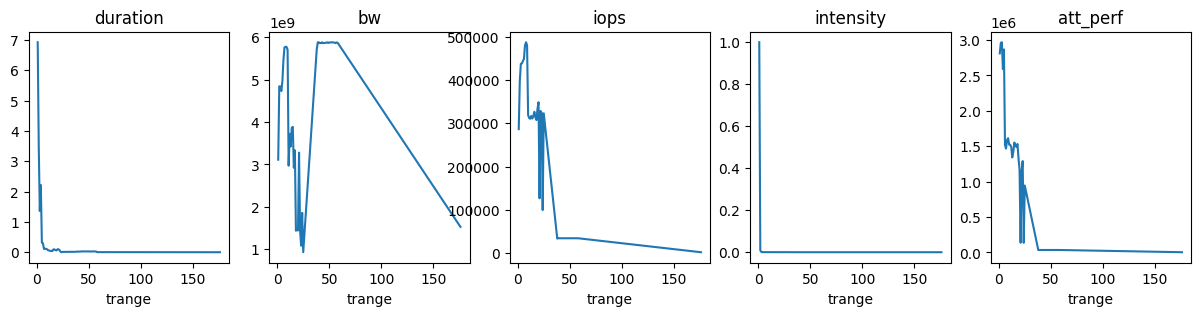

time: 2.97 s (started: 2023-06-21 11:56:37 -07:00)


In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))

trange_dur_grp_data = trange_dur_grp_view.compute()
trange_bw_grp_data = trange_bw_grp_view.compute()
trange_iops_grp_data = trange_iops_grp_view.compute()
trange_intensity_grp_data = trange_intensity_grp_view.compute()
trange_att_perf_grp_data = trange_att_perf_grp_view.compute()

trange_dur_grp_data['duration_sum'].plot.line(ax=axes[0], title='duration')
trange_bw_grp_data['bw'].plot.line(ax=axes[1], title='bw')
trange_iops_grp_data['iops'].plot.line(ax=axes[2], title='iops')
trange_intensity_grp_data['intensity'].plot.line(ax=axes[3], title='intensity')
trange_att_perf_grp_data['att_perf'].plot.line(ax=axes[4], title='att_perf')

This BW and IOPS should be translated as 'the maximum BW/IOPS a process has achieved within given trange' -- similar to 'I/O time', in which we find the maximum duration a process within a given trange/file_name achieves

## Trange Views

In [24]:
trange_dur_view, max_dur = compute_view(main_view, 'trange', 'duration_sum', max_io_time, DELTA)
trange_bw_view, max_bw = compute_view(main_view, 'trange', 'bw', None, DELTA, True, True)
trange_iops_view, max_iops = compute_view(main_view, 'trange', 'iops', None, DELTA, True, True)
trange_intensity_view, max_intensity = compute_view(main_view, 'trange', 'intensity', None, DELTA, True, False)
trange_att_perf_view, max_att_perf = compute_view(main_view, 'trange', 'att_perf', None, DELTA, True, True)

time: 333 ms (started: 2023-06-21 11:56:44 -07:00)


In [25]:
BOTTLENECK_ORDER = dict(
    app_name=('app_name', 'trange', 'file_name'),
    file_dir=('file_dir', 'proc_name', 'trange'),
    file_name=('file_name', 'proc_name', 'trange'),
    file_regex=('file_regex', 'proc_name', 'trange'),
    node_name=('node_name', 'trange', 'file_name'),
    proc_name=('proc_name', 'trange', 'file_name'),
    rank=('rank', 'trange', 'file_name'),
    trange=('trange', 'proc_name', 'file_name'),
)


def set_metric_percentages(df: pd.DataFrame, metric_col: str, metric_max: float):
    metric = metric_col.replace('_sum', '') if '_sum' in metric_col else metric_col

    pero_col, perr_col, norm_col = (
        f"{metric}_pero",
        f"{metric}_perr",
        f"{metric}_norm"
    )

    if metric_col in ['bw', 'iops', 'att_perf']:
        df[norm_col] = 1 - df[metric_col] / metric_max
        return df

    df[pero_col] = df[metric_col] / metric_max
    df[perr_col] = df[metric_col] / df[metric_col].sum()

    return df


def set_metric_scores(df: pd.DataFrame, metric_col: str, col: str, metric_max=None):
    metric = metric_col.replace('_sum', '') if '_sum' in metric_col else metric_col

    bin_col, score_col, threshold_col = (
        f"{metric}_bin",
        f"{metric}_score",
        f"{metric}_th",
    )

    is_normalized = metric_col in ['bw', 'iops', 'intensity', 'att_perf']
    is_reversed = metric_col in ['bw', 'iops', 'att_perf']

    bins = np.multiply(DELTA_BINS, metric_max) if is_normalized else DELTA_BINS
    if metric_col == 'bw':
        bins = BW_BINS
    bin_names = np.flip(DELTA_BIN_NAMES) if is_reversed else DELTA_BIN_NAMES
    th_bins = np.flip(DELTA_BINS) if is_reversed else DELTA_BINS
    
    print('set_metric_scores', metric_col, col, is_normalized, is_reversed, bins, bin_names)

    df[bin_col] = np.digitize(df[col], bins=bins, right=True)
    df[score_col] = np.choose(df[bin_col] - 1, choices=bin_names, mode='clip')
    df[threshold_col] = np.choose(df[bin_col] - 1, choices=th_bins, mode='clip')

    return df.drop(columns=[bin_col])


def generate_bottlenecks_views(
    view_type: str,
    view: dd.DataFrame,
    metric_col: str,
    metric_max: dd.core.Scalar,
):
    metric = metric_col.replace('_sum', '') if '_sum' in metric_col else metric_col

    # Create lower level view
    low_level_view = view \
        .groupby(list(BOTTLENECK_ORDER[view_type])) \
        .first()

    # Non-proc agg columns
    non_proc_agg_dict = _get_agg_dict(view_columns=low_level_view.columns, is_proc=False)
    proc_agg_dict = _get_agg_dict(view_columns=low_level_view.columns, is_proc=True)

    # Create mid and high level views
    if view_type is not PROC_COL:
        mid_level_view = low_level_view \
            .reset_index() \
            .groupby([view_type, PROC_COL]) \
            .agg(non_proc_agg_dict)

        high_level_view = mid_level_view \
            .reset_index() \
            .groupby([view_type]) \
            .agg(proc_agg_dict)
    else:
        mid_level_view = low_level_view \
            .reset_index() \
            .groupby([view_type, TRANGE_COL]) \
            .agg(non_proc_agg_dict)

        high_level_view = mid_level_view \
            .reset_index() \
            .groupby([view_type]) \
            .agg(non_proc_agg_dict)

    if metric_max is None:
        metric_max = high_level_view[metric_col].max()

    print('metric_max', metric_max.compute())

    col = f"{metric}_pero"
    if metric_col in ['bw', 'iops', 'intensity', 'att_perf']:
        col = f"{metric_col}"

    low_level_view = low_level_view \
        .map_partitions(set_metrics) \
        .map_partitions(set_metric_percentages, metric_col=metric_col, metric_max=metric_max) \
        .map_partitions(set_metric_scores, metric_col=metric_col, col=col, metric_max=metric_max)

    mid_level_view = mid_level_view \
        .map_partitions(set_metrics) \
        .map_partitions(set_metric_percentages, metric_col=metric_col, metric_max=metric_max) \
        .map_partitions(set_metric_scores, metric_col=metric_col, col=col, metric_max=metric_max)

    high_level_view = high_level_view \
        .map_partitions(set_metrics) \
        .map_partitions(set_metric_percentages, metric_col=metric_col, metric_max=metric_max) \
        .map_partitions(set_metric_scores, metric_col=metric_col, col=col, metric_max=metric_max)

    return dict(
        low_level_view=low_level_view,
        mid_level_view=mid_level_view,
        high_level_view=high_level_view,
    )


def _get_agg_dict(view_columns: list, is_proc=False):
    if is_proc:
        agg_dict = {col: max if any(x in col for x in 'duration time'.split()) else sum for col in view_columns}
    else:
        agg_dict = {col: sum for col in view_columns}
    agg_dict['size_min'] = min
    agg_dict['size_max'] = max
    for view_type in [*VIEW_TYPES, *LOGICAL_VIEW_TYPES]:
        if view_type in agg_dict:
            agg_dict.pop(view_type)
    return agg_dict

time: 7.14 ms (started: 2023-06-21 11:56:45 -07:00)


In [26]:
trange_dur_bott = generate_bottlenecks_views(view_type='trange', view=trange_dur_view, metric_col='duration_sum', metric_max=max_dur)
trange_bw_bott = generate_bottlenecks_views(view_type='trange', view=trange_bw_view, metric_col='bw', metric_max=max_bw)
trange_iops_bott = generate_bottlenecks_views(view_type='trange', view=trange_iops_view, metric_col='iops', metric_max=max_iops)
trange_intensity_bott = generate_bottlenecks_views(view_type='trange', view=trange_intensity_view, metric_col='intensity', metric_max=max_intensity)
trange_att_perf_bott = generate_bottlenecks_views(view_type='trange', view=trange_att_perf_view, metric_col='att_perf', metric_max=max_att_perf)

metric_max 8.474973793299455
set_metric_scores duration_sum duration_pero False False [0, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9] ['none', 'trivial', 'very low', 'low', 'medium', 'high', 'very high', 'critical']
set_metric_scores duration_sum duration_pero False False [0, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9] ['none', 'trivial', 'very low', 'low', 'medium', 'high', 'very high', 'critical']
set_metric_scores duration_sum duration_pero False False [0, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9] ['none', 'trivial', 'very low', 'low', 'medium', 'high', 'very high', 'critical']
metric_max 5882179169.046099
set_metric_scores bw bw True True [0, 1048576, 16777216, 268435456, 1073741824, 17179869184, 68719476736, 1099511627776] ['critical' 'very high' 'high' 'medium' 'low' 'very low' 'trivial' 'none']
set_metric_scores bw bw True True [0, 1048576, 16777216, 268435456, 1073741824, 17179869184, 68719476736, 1099511627776] ['critical' 'very high' 'high' 'medium' 'low' 'very low' 'trivial' 'none']
s

In [27]:
trange_dur_bott_hl = trange_dur_bott['high_level_view'].compute()
trange_bw_bott_hl = trange_bw_bott['high_level_view'].compute()
trange_iops_bott_hl = trange_iops_bott['high_level_view'].compute()
trange_intensity_bott_hl = trange_intensity_bott['high_level_view'].compute()
trange_att_perf_bott_hl = trange_att_perf_bott['high_level_view'].compute()

set_metric_scores duration_sum duration_pero False False [0, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9] ['none', 'trivial', 'very low', 'low', 'medium', 'high', 'very high', 'critical']
set_metric_scores bw bw True True [0, 1048576, 16777216, 268435456, 1073741824, 17179869184, 68719476736, 1099511627776] ['critical' 'very high' 'high' 'medium' 'low' 'very low' 'trivial' 'none']
set_metric_scores iops iops True True [     0.            487.86610526   4878.66105261  48786.6105261
 121966.52631525 243933.05263049 365899.57894574 439079.49473489] ['critical' 'very high' 'high' 'medium' 'low' 'very low' 'trivial' 'none']
set_metric_scores intensity intensity True False [0.    0.001 0.01  0.1   0.25  0.5   0.75  0.9  ] ['none', 'trivial', 'very low', 'low', 'medium', 'high', 'very high', 'critical']
set_metric_scores att_perf att_perf True True [      0.            2968.91361509   29689.1361509   296891.36150898
  742228.40377246 1484456.80754492 2226685.21131737 2672022.25358085] ['critical' 

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Define the colormap
cmap = plt.cm.get_cmap('RdYlGn')  # Green to Yellow to Red colormap

# Create a function to map 'duration_th' values to colors
def map_color(duration_th):
    if duration_th >= 0.9:
        return 'red'
    elif duration_th >= 0.75:
        return 'darkorange'
    elif duration_th >= 0.5:
        return 'orange'
    elif duration_th >= 0.25:
        return 'gold'
    elif duration_th >= 0.1:
        return 'yellow'
    elif duration_th >= 0.01:
        return 'yellowgreen'
    elif duration_th >= 0.001:
        return 'limegreen'
    else:
        return 'green'

time: 1.94 ms (started: 2023-06-21 11:56:53 -07:00)


<Axes: title={'center': 'duration_sum'}, xlabel='trange', ylabel='duration_sum'>

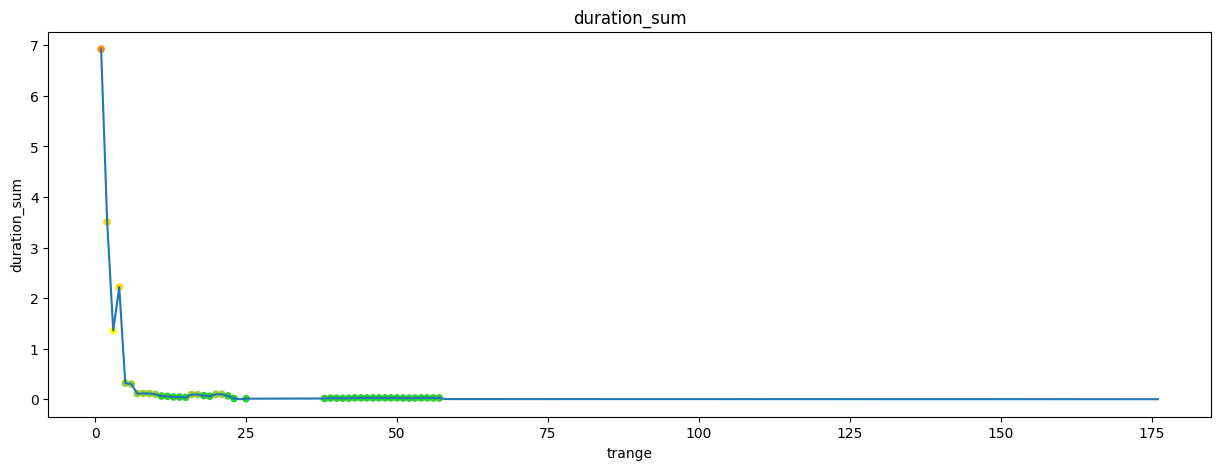

time: 565 ms (started: 2023-06-21 11:56:54 -07:00)


In [29]:
# Plot the scatter plot with fixed colormap
trange_dur_ax = trange_dur_bott_hl['duration_sum'].plot(title='duration_sum', figsize=(15, 5))
trange_dur_data = trange_dur_bott_hl.query('duration_th > 0').reset_index()
trange_dur_colors = np.vectorize(map_color)(trange_dur_data['duration_th'])
trange_dur_data.plot.scatter(ax=trange_dur_ax, x='trange', y='duration_sum', c=trange_dur_colors, cmap=cmap)

<Axes: title={'center': 'bw'}, xlabel='trange', ylabel='bw'>

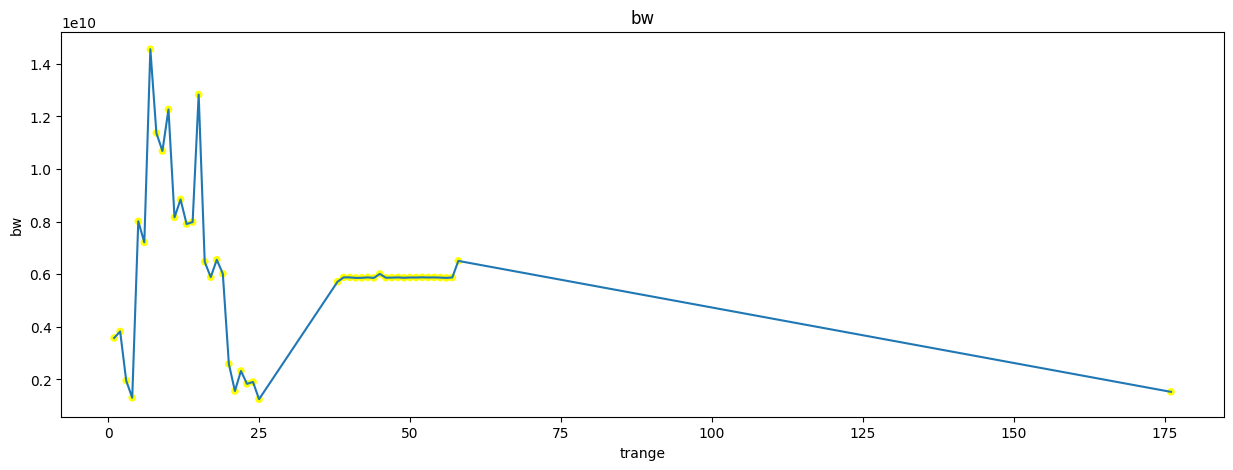

time: 444 ms (started: 2023-06-21 11:56:59 -07:00)


In [30]:
trange_bw_ax = trange_bw_bott_hl['bw'].plot(title='bw', figsize=(15, 5))
trange_bw_data = trange_bw_bott_hl.query('bw_th > 0').reset_index()
trange_bw_colors = np.vectorize(map_color)(trange_bw_data['bw_th'])
trange_bw_data.plot.scatter(ax=trange_bw_ax, x='trange', y='bw', c=trange_bw_colors, cmap=cmap)

In [31]:
trange_bw_bott_hl['bw_mb'] = trange_bw_bott_hl['bw'] / 1024 ** 2
trange_bw_bott_hl['bw_gb'] = trange_bw_bott_hl['bw'] / 1024 ** 3

time: 3.79 ms (started: 2023-06-21 11:57:05 -07:00)


In [32]:
trange_bw_bott_hl

,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,iops,intensity,id,bw_intensity,att_perf,bw_norm,bw_score,bw_th,bw_mb,bw_gb
trange,,,,,,,,,,,,,,,,,,,,,
1,6.923414,2919907,-2,178112,24761748419,1.979385,6.686495,0.286951,9373804736,15386933803,...,4.217438e+05,0.000118,5.468237e+20,2.056172e+12,6.203301e+08,0.391973,low,0.1,3410.837893,3.330896
2,3.509167,1177132,-2,172352,13419947399,0.333460,3.355307,0.055631,5889112047,7530802998,...,3.354448e+05,0.000088,-1.522140e+19,1.954852e+11,2.875887e+08,0.349858,low,0.1,3647.093011,3.561614
3,1.362043,283352,-2,172352,2662042086,1.362043,0.021420,0.014751,2279429306,382614336,...,2.080346e+05,0.000106,2.320951e+20,4.270682e+11,5.161705e+08,0.667734,low,0.1,1863.906900,1.820222
4,2.218779,504757,-2,172352,2886798369,1.568666,0.634400,0.041437,2359928760,526870045,...,2.274932e+05,0.000175,7.716636e+19,2.927873e+10,1.375696e+08,0.778811,low,0.1,1240.802140,1.211721
5,0.319489,386712,-2,172352,2560132999,0.319489,0.013256,0.003169,2318578604,241554755,...,1.210408e+06,0.000151,-6.667868e+18,2.102605e+10,1.160696e+08,-0.362287,low,0.1,7641.996693,7.462887
6,0.301292,275635,-2,172352,2172873288,0.301292,0.015047,0.002601,2022805300,150068160,...,9.148443e+05,0.000127,1.383290e+19,5.953318e+09,6.397415e+07,-0.226052,low,0.1,6877.764865,6.716567
7,0.111530,166155,-2,172352,1623478810,0.111530,0.015818,0.010276,1428255426,195223680,...,1.489776e+06,0.000102,-3.019177e+19,1.117708e+10,8.444499e+07,-1.474662,low,0.1,13882.070126,13.556709
8,0.116256,120464,-2,172352,1321807824,0.116256,0.012305,0.002837,1077970096,243838080,...,1.036195e+06,0.000091,-1.039048e+20,1.290733e+10,9.662658e+07,-0.932922,low,0.1,10843.079915,10.588945
9,0.114024,115014,-2,172352,1218611873,0.114024,0.014398,0.029829,951135113,267477120,...,1.008682e+06,0.000094,1.668654e+19,1.370137e+10,9.926021e+07,-0.816899,low,0.1,10192.230183,9.953350


time: 60.9 ms (started: 2023-06-21 11:57:06 -07:00)


In [33]:
trange_bw_bott_hl['bw_th'].value_counts()

0.1    47
Name: bw_th, dtype: int64

time: 5.27 ms (started: 2023-06-21 11:57:08 -07:00)


<Axes: title={'center': 'iops'}, xlabel='trange', ylabel='iops'>

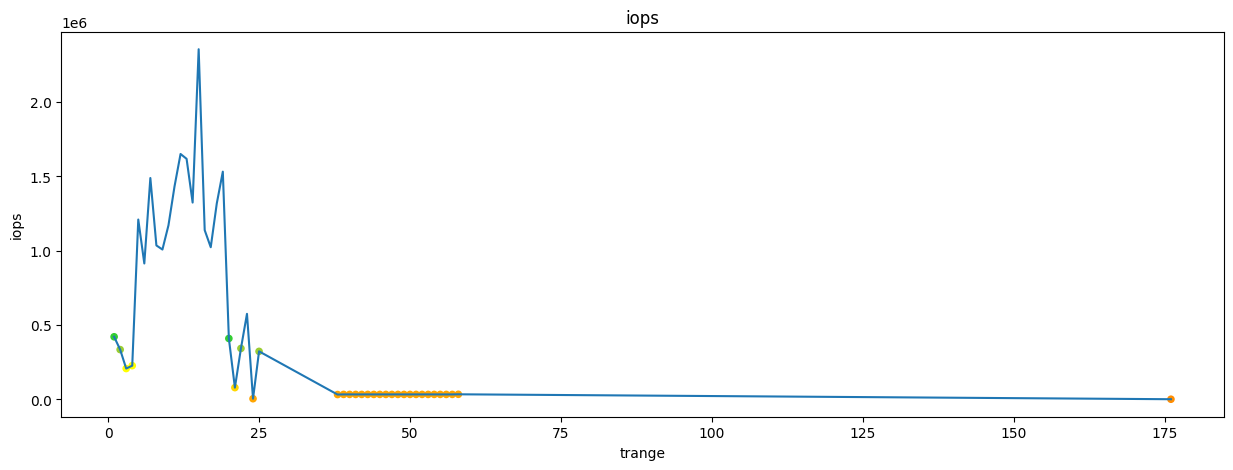

time: 416 ms (started: 2023-06-21 11:57:09 -07:00)


In [34]:
trange_iops_ax = trange_iops_bott_hl['iops'].plot(title='iops', figsize=(15, 5))
trange_iops_data = trange_iops_bott_hl.query('iops_th > 0').reset_index()
trange_iops_colors = np.vectorize(map_color)(trange_iops_data['iops_th'])
trange_iops_data.plot.scatter(ax=trange_iops_ax, x='trange', y='iops', c=trange_iops_colors, cmap=cmap)

In [ ]:
trange_intensity_ax = trange_intensity_bott_hl['intensity'].plot(title='intensity', figsize=(15, 5))
trange_intensity_data = trange_intensity_bott_hl.query('intensity_th > 0').reset_index()
trange_intensity_colors = np.vectorize(map_color)(trange_intensity_data['intensity_th'])
trange_intensity_data.plot.scatter(ax=trange_intensity_ax, x='trange', y='intensity', c=trange_intensity_colors, cmap=cmap)

<Axes: title={'center': 'att_perf'}, xlabel='trange', ylabel='att_perf'>

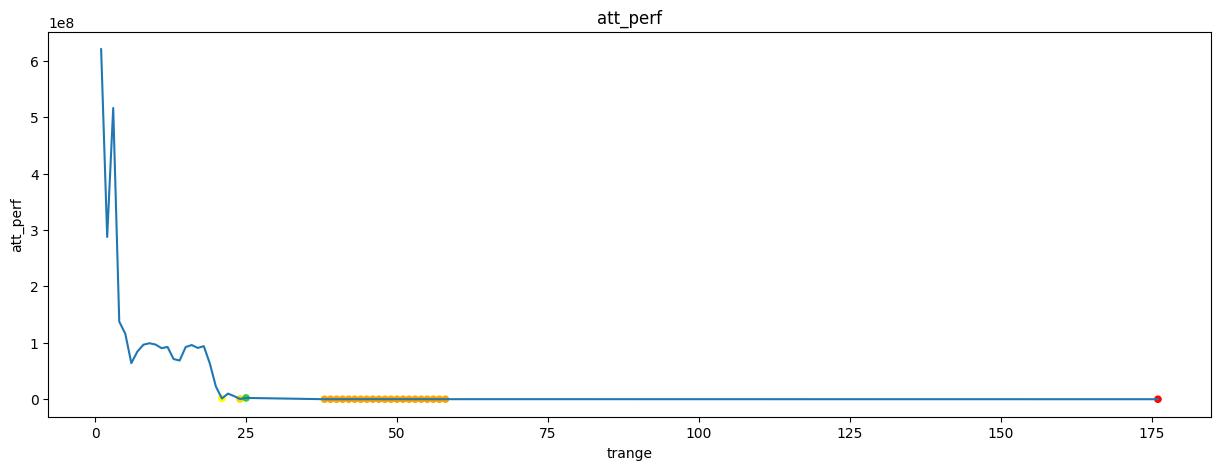

time: 609 ms (started: 2023-06-21 11:57:40 -07:00)


In [36]:
trange_att_perf_ax = trange_att_perf_bott_hl['att_perf'].plot(title='att_perf', figsize=(15, 5))
trange_att_perf_data = trange_att_perf_bott_hl.query('att_perf_th > 0').reset_index()
trange_att_perf_colors = np.vectorize(map_color)(trange_att_perf_data['att_perf_th'])
trange_att_perf_data.plot.scatter(ax=trange_att_perf_ax, x='trange', y='att_perf', c=trange_att_perf_colors, cmap=cmap)

<Axes: title={'center': 'att_perf'}, xlabel='trange', ylabel='att_perf'>

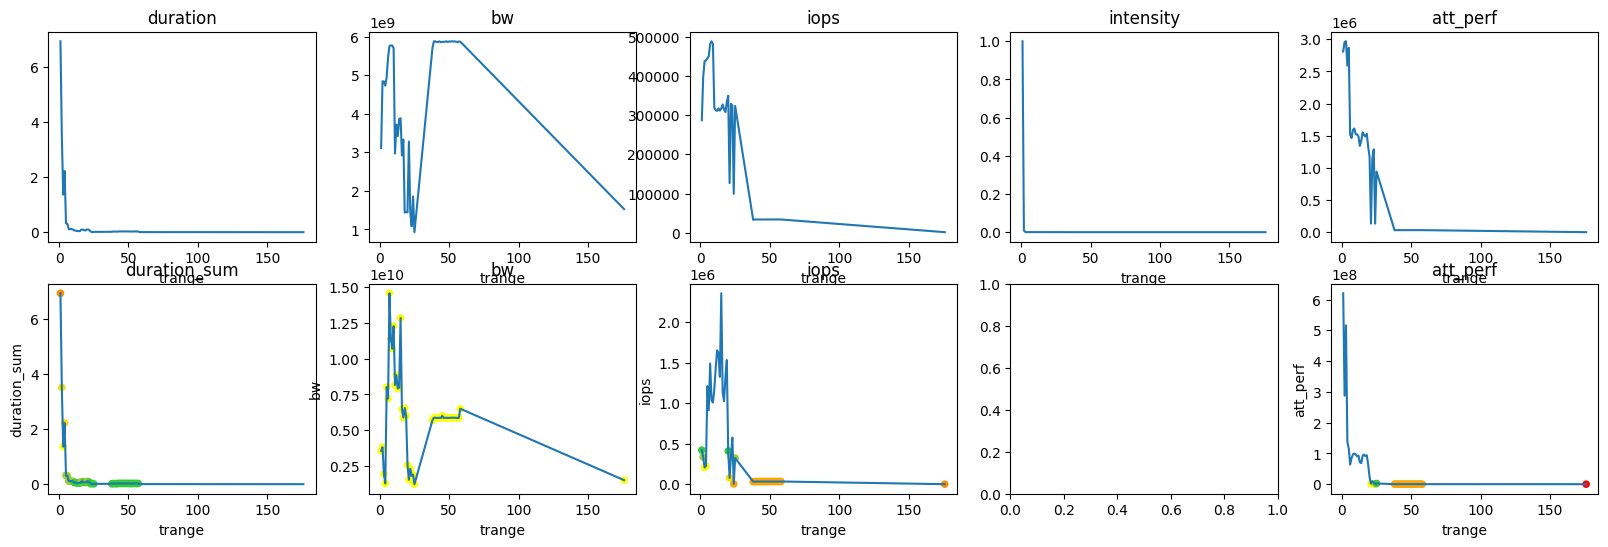

time: 2.97 s (started: 2023-06-21 11:57:49 -07:00)


In [38]:
trange_fig, trange_axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 6))

trange_dur_grp_data['duration_sum'].plot.line(ax=trange_axes[0, 0], title='duration')
trange_bw_grp_data['bw'].plot.line(ax=trange_axes[0, 1], title='bw')
trange_iops_grp_data['iops'].plot.line(ax=trange_axes[0, 2], title='iops')
trange_intensity_grp_data['intensity'].plot.line(ax=trange_axes[0, 3], title='intensity')
trange_att_perf_grp_data['att_perf'].plot.line(ax=trange_axes[0, 4], title='att_perf')

trange_dur_bott_hl['duration_sum'].plot(ax=trange_axes[1, 0], title='duration_sum')
trange_dur_data.plot.scatter(ax=trange_axes[1, 0], x='trange', y='duration_sum', c=trange_dur_colors, cmap=cmap)

trange_bw_bott_hl['bw'].plot(ax=trange_axes[1, 1], title='bw')
trange_bw_data.plot.scatter(ax=trange_axes[1, 1], x='trange', y='bw', c=trange_bw_colors, cmap=cmap)

trange_iops_bott_hl['iops'].plot(ax=trange_axes[1, 2], title='iops')
trange_iops_data.plot.scatter(ax=trange_axes[1, 2], x='trange', y='iops', c=trange_iops_colors, cmap=cmap)

# trange_intensity_bott_hl['intensity'].plot(ax=trange_axes[1, 3], title='intensity')
# trange_intensity_data.plot.scatter(ax=trange_axes[1, 3], x='trange', y='intensity', c=trange_intensity_colors, cmap=cmap)

trange_att_perf_bott_hl['att_perf'].plot(ax=trange_axes[1, 4], title='att_perf')
trange_att_perf_data.plot.scatter(ax=trange_axes[1, 4], x='trange', y='att_perf', c=trange_att_perf_colors, cmap=cmap)

## Proc_name Views

In [45]:
proc_name_views = {
    'duration_sum': compute_view(main_view, 'proc_name', 'duration_sum', max_io_time, DELTA),
    'bw': compute_view(main_view, 'proc_name', 'bw', max_bw, DELTA, True),
    'iops': compute_view(main_view, 'proc_name', 'iops', max_iops, DELTA, True),
}

time: 150 ms (started: 2023-06-05 14:08:58 -07:00)


In [46]:
proc_name_views['duration_sum'].compute()

duration_sum  \
trange file_name                                          proc_name                                          
1      /dev/null                                          app1#localhost#17#35184372411024        0.000003   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024        0.001609   
3      /dev/null                                          app1#localhost#1000#35184372411024      0.000003   
                                                          app1#localhost#1038#35184372411024      0.000003   
                                                          app1#localhost#1040#35184372411024      0.000003   
...                                                                                                    ...   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#840#35184372411024       0.000005   
                                                          app1#localhost#880#35184372411024       0.000005   
                                                          app1#localhost#920#35184372411024       0.000005   
                                                          app1#localhost#960#35184372411024       0.000005   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         0.000226   

                                                                                              index_count  \
trange file_name                                          proc_name                                         
1      /dev/null                                          app1#localhost#17#35184372411024              1   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024              5   
3      /dev/null                                          app1#localhost#1000#35184372411024            1   
                                                          app1#localhost#1038#35184372411024            1   
                                                          app1#localhost#1040#35184372411024            1   
...                                                                                                   ...   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#840#35184372411024             1   
                                                          app1#localhost#880#35184372411024             1   
                                                          app1#localhost#920#35184372411024             1   
                                                          app1#localhost#960#35184372411024             1   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024               2   

                                                                                              size_min  \
trange file_name                                          proc_name                                      
1      /dev/null                                          app1#localhost#17#35184372411024           0   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024    16777216   
3      /dev/null                                          app1#localhost#1000#35184372411024         0   
                                                          app1#localhost#1038#35184372411024         0   
                                                          app1#localhost#1040#35184372411024         0   
...                                                                                                ...   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#840#35184372411024          0   
                                                          app1#localhost#880#35184372411024          0   
                                                          app1#localhost#920#35184372411024          0   
                                                          app1#localhost#960#35

time: 196 ms (started: 2023-06-05 14:08:58 -07:00)


In [47]:
proc_name_views['bw'].compute()

duration_sum  \
trange file_name                                          proc_name                                          
3      /dev/null                                          app1#localhost#1000#35184372411024      0.000003   
                                                          app1#localhost#1040#35184372411024      0.000003   
                                                          app1#localhost#1080#35184372411024      0.000002   
                                                          app1#localhost#1120#35184372411024      0.000003   
                                                          app1#localhost#1160#35184372411024      0.000003   
...                                                                                                    ...   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#800#35184372411024       0.000005   
                                                          app1#localhost#840#35184372411024       0.000005   
                                                          app1#localhost#880#35184372411024       0.000005   
                                                          app1#localhost#920#35184372411024       0.000005   
                                                          app1#localhost#960#35184372411024       0.000005   

                                                                                              index_count  \
trange file_name                                          proc_name                                         
3      /dev/null                                          app1#localhost#1000#35184372411024            1   
                                                          app1#localhost#1040#35184372411024            1   
                                                          app1#localhost#1080#35184372411024            1   
                                                          app1#localhost#1120#35184372411024            1   
                                                          app1#localhost#1160#35184372411024            1   
...                                                                                                   ...   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#800#35184372411024             1   
                                                          app1#localhost#840#35184372411024             1   
                                                          app1#localhost#880#35184372411024             1   
                                                          app1#localhost#920#35184372411024             1   
                                                          app1#localhost#960#35184372411024             1   

                                                                                              size_min  \
trange file_name                                          proc_name                                      
3      /dev/null                                          app1#localhost#1000#35184372411024         0   
                                                          app1#localhost#1040#35184372411024         0   
                                                          app1#localhost#1080#35184372411024         0   
                                                          app1#localhost#1120#35184372411024         0   
                                                          app1#localhost#1160#35184372411024         0   
...                                                                                                ...   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#800#35184372411024          0   
                                                          app1#localhost#840#35184372411024          0   
                                                          app1#localhost#880#35184372411024          0   
                                                          app1#localhost#920#35

time: 262 ms (started: 2023-06-05 14:08:59 -07:00)


In [48]:
proc_name_views['iops'].compute()

,,,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,seek_time,stat_time,close_count,open_count,seek_count,stat_count,bw,iops,intensity,id
trange,file_name,proc_name,,,,,,,,,,,,,,,,,,,,,


time: 196 ms (started: 2023-06-05 14:08:59 -07:00)


In [49]:
proc_name_botts = {}
for t in proc_name_views:
    proc_name_botts[t] = generate_bottlenecks_views(
        view_type='proc_name',
        view=proc_name_views[t],
        metric_col=t,
        metric_max=max_io_time if t == 'duration_sum' else max_bw if t == 'bw' else max_iops,
        is_reversed=t != 'duration_sum'
    )

time: 1.39 s (started: 2023-06-05 14:08:59 -07:00)


In [50]:
proc_name_dur_bot_ll = proc_name_botts['duration_sum']['low_level_view'].compute()
proc_name_dur_bot_ll

duration_sum  \
proc_name                         trange file_name                                                          
app1#localhost#0#35184372411024   3      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000034   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.020722   
                                  4      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.001437   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.002457   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000003   
...                                                                                                   ...   
app1#localhost#960#35184372411024 668    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000147   
                                  669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000033   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000005   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000004   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000005   

                                                                                             index_count  \
proc_name                         trange file_name                                                         
app1#localhost#0#35184372411024   3      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            5   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            6   
                                  4      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            5   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            8   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   
...                                                                                                  ...   
app1#localhost#960#35184372411024 668    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            3   
                                  669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   

                                                                                             size_min  \
proc_name                         trange file_name                                                      
app1#localhost#0#35184372411024   3      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...  16777216   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
                                  4      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...  16777216   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      2055   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
...                                                                                               ...   
app1#localhost#960#35184372411024 668    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
                                  669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
          

time: 310 ms (started: 2023-06-05 14:09:01 -07:00)


In [51]:
proc_name_bw_bot_ll = proc_name_botts['bw']['low_level_view'].compute()
proc_name_bw_bot_ll

duration_sum  \
proc_name                          trange file_name                                                          
app1#localhost#1000#35184372411024 3      /dev/null                                               0.000003   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000039   
                                   4      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000003   
                                   5      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      2.151723   
                                   6      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000003   
...                                                                                                    ...   
app1#localhost#960#35184372411024  668    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000147   
                                   669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000033   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000005   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000004   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000005   

                                                                                              index_count  \
proc_name                          trange file_name                                                         
app1#localhost#1000#35184372411024 3      /dev/null                                                     1   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            5   
                                   4      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   
                                   5      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   
                                   6      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            2   
...                                                                                                   ...   
app1#localhost#960#35184372411024  668    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            3   
                                   669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   

                                                                                              size_min  \
proc_name                          trange file_name                                                      
app1#localhost#1000#35184372411024 3      /dev/null                                                  0   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...  16777216   
                                   4      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
                                   5      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
                                   6      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
...                                                                                                ...   
app1#localhost#960#35184372411024  668    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
                                   669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/c

time: 227 ms (started: 2023-06-05 14:09:02 -07:00)


In [52]:
proc_name_iops_bot_ll = proc_name_botts['iops']['low_level_view'].compute()
proc_name_iops_bot_ll

,,,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,seek_count,stat_count,bw,iops,intensity,id,iops_pero,iops_perr,iops_score,iops_th
proc_name,trange,file_name,,,,,,,,,,,,,,,,,,,,,


time: 215 ms (started: 2023-06-05 14:09:02 -07:00)


## File_name Views

In [53]:
file_name_views = {
    'duration_sum': compute_view(main_view, 'file_name', 'duration_sum', max_io_time, DELTA),
    'bw': compute_view(main_view, 'file_name', 'bw', max_bw, DELTA, True),
    'iops': compute_view(main_view, 'file_name', 'iops', max_iops, DELTA, True),
}

time: 259 ms (started: 2023-06-05 14:09:03 -07:00)


In [54]:
file_name_views['duration_sum'].compute()

duration_sum  \
trange file_name                                          proc_name                                         
1      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024       0.001609   
3      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024        0.000034   
                                                          app1#localhost#1#35184372411024        0.000037   
                                                          app1#localhost#10#35184372411024       0.000035   
                                                          app1#localhost#100#35184372411024      0.000037   
...                                                                                                   ...   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#840#35184372411024      0.000005   
                                                          app1#localhost#880#35184372411024      0.000005   
                                                          app1#localhost#920#35184372411024      0.000005   
                                                          app1#localhost#960#35184372411024      0.000005   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024        0.000226   

                                                                                             index_count  \
trange file_name                                          proc_name                                        
1      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024             5   
3      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024              5   
                                                          app1#localhost#1#35184372411024              5   
                                                          app1#localhost#10#35184372411024             5   
                                                          app1#localhost#100#35184372411024            5   
...                                                                                                  ...   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#840#35184372411024            1   
                                                          app1#localhost#880#35184372411024            1   
                                                          app1#localhost#920#35184372411024            1   
                                                          app1#localhost#960#35184372411024            1   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024              2   

                                                                                             size_min  \
trange file_name                                          proc_name                                     
1      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024   16777216   
3      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    16777216   
                                                          app1#localhost#1#35184372411024    16777216   
                                                          app1#localhost#10#35184372411024   16777216   
                                                          app1#localhost#100#35184372411024  16777216   
...                                                                                               ...   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#840#35184372411024         0   
                                                          app1#localhost#880#35184372411024         0   
                                                          app1#localhost#920#35184372411024         0   
                                                          app1#localhost#960#35184372411024         0   
       /p/

time: 195 ms (started: 2023-06-05 14:09:03 -07:00)


In [55]:
file_name_views['bw'].compute()

duration_sum  \
trange file_name                                          proc_name                                          
1      /dev/null                                          app1#localhost#17#35184372411024        0.000003   
3      /dev/null                                          app1#localhost#1#35184372411024         0.000003   
                                                          app1#localhost#10#35184372411024        0.000002   
                                                          app1#localhost#100#35184372411024       0.000003   
                                                          app1#localhost#1000#35184372411024      0.000003   
...                                                                                                    ...   
668    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         0.000140   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         0.000134   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         0.000141   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         0.000311   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         0.000226   

                                                                                              index_count  \
trange file_name                                          proc_name                                         
1      /dev/null                                          app1#localhost#17#35184372411024              1   
3      /dev/null                                          app1#localhost#1#35184372411024               1   
                                                          app1#localhost#10#35184372411024              1   
                                                          app1#localhost#100#35184372411024             1   
                                                          app1#localhost#1000#35184372411024            1   
...                                                                                                   ...   
668    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024               7   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024               7   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024               7   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024               6   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024               2   

                                                                                              size_min  \
trange file_name                                          proc_name                                      
1      /dev/null                                          app1#localhost#17#35184372411024           0   
3      /dev/null                                          app1#localhost#1#35184372411024            0   
                                                          app1#localhost#10#35184372411024           0   
                                                          app1#localhost#100#35184372411024          0   
                                                          app1#localhost#1000#35184372411024         0   
...                                                                                                ...   
668    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         2602   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         2602   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         3491   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#3518

time: 187 ms (started: 2023-06-05 14:09:03 -07:00)


In [56]:
file_name_views['iops'].compute()

,,,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,seek_time,stat_time,close_count,open_count,seek_count,stat_count,bw,iops,intensity,id
trange,file_name,proc_name,,,,,,,,,,,,,,,,,,,,,


time: 170 ms (started: 2023-06-05 14:09:04 -07:00)


In [57]:
file_name_botts = {}
for t in file_name_views:
    file_name_botts[t] = generate_bottlenecks_views(
        view_type='file_name',
        view=file_name_views[t],
        metric_col=t,
        metric_max=max_io_time if t == 'duration_sum' else max_bw if t == 'bw' else max_iops,
        is_reversed=t != 'duration_sum'
    )

time: 833 ms (started: 2023-06-05 14:09:04 -07:00)


In [58]:
file_name_dur_bot_ll = file_name_botts['duration_sum']['low_level_view'].compute()
file_name_dur_bot_ll

duration_sum  \
file_name                                          proc_name                          trange                 
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    4           0.001437   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    4           0.002457   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    6           0.005920   
                                                                                      7           0.001533   
                                                   app1#localhost#1000#35184372411024 4           0.000003   
...                                                                                                    ...   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#997#35184372411024  3           0.000036   
                                                   app1#localhost#998#35184372411024  3           0.000037   
                                                   app1#localhost#999#35184372411024  3           0.000035   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    3           0.020722   
                                                                                      4           0.000192   

                                                                                              index_count  \
file_name                                          proc_name                          trange                
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    4                 5   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    4                 8   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    6                 5   
                                                                                      7                 2   
                                                   app1#localhost#1000#35184372411024 4                 1   
...                                                                                                   ...   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#997#35184372411024  3                 5   
                                                   app1#localhost#998#35184372411024  3                 5   
                                                   app1#localhost#999#35184372411024  3                 5   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    3                 6   
                                                                                      4                 2   

                                                                                              size_min  \
file_name                                          proc_name                          trange             
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    4       16777216   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    4           2055   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    6       16777216   
                                                                                      7       11010048   
                                                   app1#localhost#1000#35184372411024 4              0   
...                                                                                                ...   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#997#35184372411024  3       16777216   
                                                   app1#localhost#998#35184372411024  3       16777216   
                                                   app1#localhost#999#35184372411024  3       16777216   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411

time: 301 ms (started: 2023-06-05 14:09:05 -07:00)


In [59]:
file_name_bw_bot_ll = file_name_botts['bw']['low_level_view'].compute()
file_name_bw_bot_ll

duration_sum  \
file_name                                          proc_name                          trange                 
/dev/null                                          app1#localhost#1#35184372411024    3           0.000003   
                                                   app1#localhost#10#35184372411024   3           0.000002   
                                                   app1#localhost#100#35184372411024  3           0.000003   
                                                   app1#localhost#1000#35184372411024 3           0.000003   
                                                   app1#localhost#1001#35184372411024 3           0.000003   
...                                                                                                    ...   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    345         0.000904   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    668         0.000311   
                                                                                      669         0.000226   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    3           0.020722   
                                                                                      4           0.000192   

                                                                                              index_count  \
file_name                                          proc_name                          trange                
/dev/null                                          app1#localhost#1#35184372411024    3                 1   
                                                   app1#localhost#10#35184372411024   3                 1   
                                                   app1#localhost#100#35184372411024  3                 1   
                                                   app1#localhost#1000#35184372411024 3                 1   
                                                   app1#localhost#1001#35184372411024 3                 1   
...                                                                                                   ...   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    345               8   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    668               6   
                                                                                      669               2   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    3                 6   
                                                                                      4                 2   

                                                                                              size_min  \
file_name                                          proc_name                          trange             
/dev/null                                          app1#localhost#1#35184372411024    3              0   
                                                   app1#localhost#10#35184372411024   3              0   
                                                   app1#localhost#100#35184372411024  3              0   
                                                   app1#localhost#1000#35184372411024 3              0   
                                                   app1#localhost#1001#35184372411024 3              0   
...                                                                                                ...   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    345         6112   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    668            0   
                                                                                      669         6112   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411

time: 337 ms (started: 2023-06-05 14:09:05 -07:00)


In [60]:
file_name_iops_bot_ll = file_name_botts['iops']['low_level_view'].compute()
file_name_iops_bot_ll

,,,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,seek_count,stat_count,bw,iops,intensity,id,iops_pero,iops_perr,iops_score,iops_th
file_name,proc_name,trange,,,,,,,,,,,,,,,,,,,,,


time: 382 ms (started: 2023-06-05 14:09:06 -07:00)


## Analysis

In [61]:
bott_merged = pd.concat([
    trange_dur_bott_ll,
    trange_bw_bott_ll,
    trange_iops_bott_ll,
    proc_name_dur_bot_ll,
    proc_name_bw_bot_ll,
    proc_name_iops_bot_ll,
    file_name_dur_bot_ll,
    file_name_bw_bot_ll,
    file_name_iops_bot_ll,
], ignore_index=True)
bott_merged

,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,duration_score,duration_th,bw_pero,bw_perr,bw_score,bw_th,iops_pero,iops_perr,iops_score,iops_th
0,0.000003,1,0,0,0,0.000000,0.000000,0.000003,0,0,...,none,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.001609,5,16777216,16777216,16777216,0.001470,0.000000,0.000139,16777216,0,...,none,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000034,5,16777216,16777216,16777216,0.000009,0.000000,0.000025,16777216,0,...,none,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.020722,6,0,0,0,0.000000,0.000000,0.020722,0,0,...,trivial,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000003,1,0,0,0,0.000000,0.000000,0.000003,0,0,...,none,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22003,0.000904,8,6112,6112,6112,0.000000,0.000154,0.000750,0,6112,...,NaN,NaN,0.000013,0.000100,very high,0.75,NaN,NaN,NaN,NaN
22004,0.000311,6,0,0,0,0.000000,0.000000,0.000311,0,0,...,NaN,NaN,0.000000,0.000000,very high,0.75,NaN,NaN,NaN,NaN
22005,0.000226,2,6112,6112,6112,0.000000,0.000153,0.000073,0,6112,...,NaN,NaN,0.000053,0.000398,very high,0.75,NaN,NaN,NaN,NaN
22006,0.020722,6,0,0,0,0.000000,0.000000,0.020722,0,0,...,NaN,NaN,0.000000,0.000000,very high,0.75,NaN,NaN,NaN,NaN


time: 133 ms (started: 2023-06-05 14:09:07 -07:00)


In [62]:
recurring_ids = bott_merged['id'].value_counts()
recurring_ids

 8159149759523871790    6
-3580648880550333853    6
 2049833725897262901    6
-8750083313744262995    6
 1319174540603289259    6
                       ..
 6299769423444245045    2
-6589248155319838959    2
-8135257349364404327    2
 6202131317584764575    2
-2907254756546469629    2
Name: id, Length: 6726, dtype: int64

time: 8.13 ms (started: 2023-06-05 14:09:08 -07:00)


<Axes: ylabel='id'>

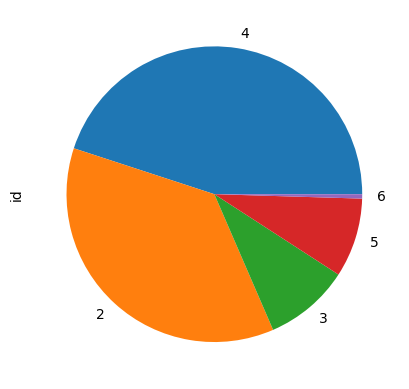

time: 187 ms (started: 2023-06-05 14:09:08 -07:00)


In [63]:
recurring_ids.value_counts().plot.pie()

In [64]:
most_recurring_ids = recurring_ids[recurring_ids == 6]
most_recurring_ids

 8159149759523871790    6
-3580648880550333853    6
 2049833725897262901    6
-8750083313744262995    6
 1319174540603289259    6
 9046877151916567929    6
 3551969272465241348    6
-7417298176380334998    6
-2882538150951803522    6
-3246852102937042135    6
 5695934534717213566    6
-5195052300134216569    6
-1342937767561985998    6
 507466036300524020     6
 3294435043668060302    6
 4994763547029287203    6
-939230427729634983     6
 1300398369164823999    6
-2162579097662219064    6
 863074684830707321     6
-6505113466893468195    6
-5925359111880137852    6
-388973643969515740     6
-7372192307012695496    6
 6613042384359419540    6
-5542846963605308636    6
 4384684247706470375    6
-2322742444232083590    6
-8331575384389315226    6
 4854585461981606144    6
-1020569491675474462    6
-8062162919346696497    6
Name: id, dtype: int64

time: 5.7 ms (started: 2023-06-05 14:09:08 -07:00)


In [65]:
most_recurring_ll = bott_merged[bott_merged['id'].isin(most_recurring_ids.index)]
most_recurring_ll

,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,duration_score,duration_th,bw_pero,bw_perr,bw_score,bw_th,iops_pero,iops_perr,iops_score,iops_th
2596,1.970968,1,0,0,0,0.0,0.0,1.970968,0,0,...,medium,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2597,2.151723,1,0,0,0,0.0,0.0,2.151723,0,0,...,high,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2598,1.952563,1,0,0,0,0.0,0.0,1.952563,0,0,...,medium,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2599,2.116145,1,0,0,0,0.0,0.0,2.116145,0,0,...,high,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2600,2.116290,1,0,0,0,0.0,0.0,2.116290,0,0,...,high,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13959,2.164203,1,0,0,0,0.0,0.0,2.164203,0,0,...,high,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13963,2.010935,1,0,0,0,0.0,0.0,2.010935,0,0,...,medium,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13967,2.164720,1,0,0,0,0.0,0.0,2.164720,0,0,...,high,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16859,1.970968,1,0,0,0,0.0,0.0,1.970968,0,0,...,medium,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


time: 47.8 ms (started: 2023-06-05 14:09:08 -07:00)


In [66]:
most_recurring_ll.groupby(['id']).first()

,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,duration_score,duration_th,bw_pero,bw_perr,bw_score,bw_th,iops_pero,iops_perr,iops_score,iops_th
id,,,,,,,,,,,,,,,,,,,,,
-8750083313744262995,2.054732,1,0,0,0,0.0,0.0,2.054732,0,0,...,medium,0.25,0.0,0.0,very high,0.75,0.000003,0.031690,very high,0.75
-8331575384389315226,2.116145,1,0,0,0,0.0,0.0,2.116145,0,0,...,high,0.50,0.0,0.0,very high,0.75,0.000003,0.030770,very high,0.75
-8062162919346696497,1.970968,1,0,0,0,0.0,0.0,1.970968,0,0,...,medium,0.25,0.0,0.0,very high,0.75,0.000003,0.033036,very high,0.75
-7417298176380334998,2.164277,1,0,0,0,0.0,0.0,2.164277,0,0,...,high,0.50,0.0,0.0,very high,0.75,0.000003,0.030086,very high,0.75
-7372192307012695496,2.151049,1,0,0,0,0.0,0.0,2.151049,0,0,...,high,0.50,0.0,0.0,very high,0.75,0.000003,0.030271,very high,0.75
-6505113466893468195,2.054112,1,0,0,0,0.0,0.0,2.054112,0,0,...,medium,0.25,0.0,0.0,very high,0.75,0.000003,0.031699,very high,0.75
-5925359111880137852,2.151693,1,0,0,0,0.0,0.0,2.151693,0,0,...,high,0.50,0.0,0.0,very high,0.75,0.000003,0.030262,very high,0.75
-5542846963605308636,2.129455,1,0,0,0,0.0,0.0,2.129455,0,0,...,high,0.50,0.0,0.0,very high,0.75,0.000003,0.030578,very high,0.75
-5195052300134216569,2.164769,1,0,0,0,0.0,0.0,2.164769,0,0,...,high,0.50,0.0,0.0,very high,0.75,0.000003,0.030079,very high,0.75


time: 112 ms (started: 2023-06-05 14:09:09 -07:00)


In [67]:
main_view[main_view['id'].isin(most_recurring_ids.index)].compute()

duration_sum  \
trange file_name                                          proc_name                                          
5      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#1000#35184372411024      2.151723   
                                                          app1#localhost#1040#35184372411024      1.952563   
                                                          app1#localhost#1080#35184372411024      2.116145   
                                                          app1#localhost#1120#35184372411024      2.116290   
                                                          app1#localhost#1160#35184372411024      2.026798   
                                                          app1#localhost#120#35184372411024       2.129455   
                                                          app1#localhost#1200#35184372411024      2.025340   
                                                          app1#localhost#1240#35184372411024      2.151049   
                                                          app1#localhost#160#35184372411024       2.069059   
                                                          app1#localhost#200#35184372411024       2.151693   
                                                          app1#localhost#240#35184372411024       2.054112   
                                                          app1#localhost#280#35184372411024       2.139112   
                                                          app1#localhost#320#35184372411024       2.054134   
                                                          app1#localhost#360#35184372411024       2.165936   
                                                          app1#localhost#40#35184372411024        1.939239   
                                                          app1#localhost#400#35184372411024       2.191390   
                                                          app1#localhost#440#35184372411024       1.992225   
                                                          app1#localhost#480#35184372411024       2.114179   
                                                          app1#localhost#520#35184372411024       2.164664   
                                                          app1#localhost#560#35184372411024       2.164769   
                                                          app1#localhost#600#35184372411024       2.191843   
                                                          app1#localhost#640#35184372411024       2.099467   
                                                          app1#localhost#680#35184372411024       1.970162   
                                                          app1#localhost#720#35184372411024       2.164277   
                                                          app1#localhost#760#35184372411024       1.952886   
                                                          app1#localhost#80#35184372411024        2.167557   
                                                          app1#localhost#800#35184372411024       1.994138   
                                                          app1#localhost#840#35184372411024       2.054732   
                                                          app1#localhost#880#35184372411024       2.164203   
                                                          app1#localhost#920#35184372411024       2.010935   
                                                          app1#localhost#960#35184372411024       2.164720   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         1.970968   

                                                                                              index_count  \
trange file_name                                          proc_name                                         
5      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#1000#35184372411024            1   
                          

time: 100 ms (started: 2023-06-05 14:09:09 -07:00)
